In [ ]:
# ''' MLP '''
# class MLP(nn.Module):
#     def __init__(self, channel, num_classes):
#         super(MLP, self).__init__()
#         self.fc_1 = nn.Linear(28*28*1 if channel==1 else 32*32*3, 128)
#         self.fc_2 = nn.Linear(128, 128)
#         self.fc_3 = nn.Linear(128, num_classes)

#     def forward(self, x):
#         out = x.view(x.size(0), -1)
#         out = F.relu(self.fc_1(out))
#         out = F.relu(self.fc_2(out))
#         out = self.fc_3(out)
#         return out

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms

In [ ]:
class MLP(nn.Module):
    def __init__(self, channel, num_classes):
        super(MLP, self).__init__()
        self.fc_1 = nn.Linear(28 * 28 * 1 if channel == 1 else 32 * 32 * 3, 128)
        self.fc_2 = nn.Linear(128, 128)
        self.fc_3 = nn.Linear(128, num_classes)

    def forward(self, x):
        out = x.view(x.size(0), -1)
        out = F.relu(self.fc_1(out))
        out = F.relu(self.fc_2(out))
        out = self.fc_3(out)
        return out

In [ ]:
def gradient_matching_algorithm(model, dataset, lr_condensed=0.1, num_iterations=10, num_opt_steps=1):
    # Define optimizer for condensed samples
    optimizer_condensed = optim.SGD(model.parameters(), lr=lr_condensed)

    for iteration in range(num_iterations):
        # Randomly initialize weights
        model.apply(random_weights_initialization)

        # Train on the synthetic dataset
        for step in range(num_opt_steps):
            # Sample mini-batch from the synthetic dataset
            inputs, targets = sample_mini_batch(dataset, minibatch_size=256)

            # Forward pass
            outputs = model(inputs)
            loss = F.cross_entropy(outputs, targets)

            # Backward pass and optimization
            optimizer_condensed.zero_grad()
            loss.backward()
            optimizer_condensed.step()

    return model

In [ ]:
def train_model(model, train_loader, lr_model=0.01, num_opt_steps_model=50):
    # Define optimizer for the model
    optimizer_model = optim.SGD(model.parameters(), lr=lr_model)

    for epoch in range(num_opt_steps_model):
        model.apply(random_weights_initialization)
        for data, target in train_loader:
            # Zero the gradients
            optimizer_model.zero_grad()

            # Forward pass
            output = model(data)
            loss = F.cross_entropy(output, target)

            # Backward pass and optimization
            loss.backward()
            optimizer_model.step()

    return model

In [ ]:
import torch
from torch.utils.data import Subset, DataLoader

def condense_dataset(dataset, num_images_per_class):
    condensed_indices = []
    classes = dataset.targets.unique()

    for class_label in classes:
        class_indices = (dataset.targets == class_label).nonzero(as_tuple=True)[0]
        selected_indices = class_indices[:num_images_per_class]
        condensed_indices.extend(selected_indices.tolist())

    condensed_dataset = Subset(dataset, condensed_indices)
    return condensed_dataset

In [ ]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
mnist_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)

# Assuming you want to condense the dataset to 10 images per class
condensed_dataset = condense_dataset(mnist_dataset, num_images_per_class=10)

In [ ]:
import torch.nn.init as init

def random_weights_initialization(module):
    if isinstance(module, nn.Linear):
        init.normal_(module.weight)
        init.constant_(module.bias, 0)

In [ ]:
import torch.utils.data as data

def sample_mini_batch(dataset, minibatch_size):
    data_loader = data.DataLoader(dataset, batch_size=minibatch_size, shuffle=True)
    data_iter = iter(data_loader)
    inputs, targets = next(data_iter)

    return inputs, targets

inputs, targets = sample_mini_batch(condensed_dataset, minibatch_size=256)

In [ ]:
# Initialize the model
model = MLP(channel=1, num_classes=10)

# Use the gradient matching algorithm to generate the synthetic dataset
model = gradient_matching_algorithm(model, condensed_dataset, lr_condensed=0.1, num_iterations=10, num_opt_steps=1)

# Define data loader for the synthetic dataset
synthetic_loader = torch.utils.data.DataLoader(condensed_dataset, batch_size=256, shuffle=True)

# Train the model on the synthetic dataset
trained_model = train_model(model, synthetic_loader, lr_model=0.01, num_opt_steps_model=50)

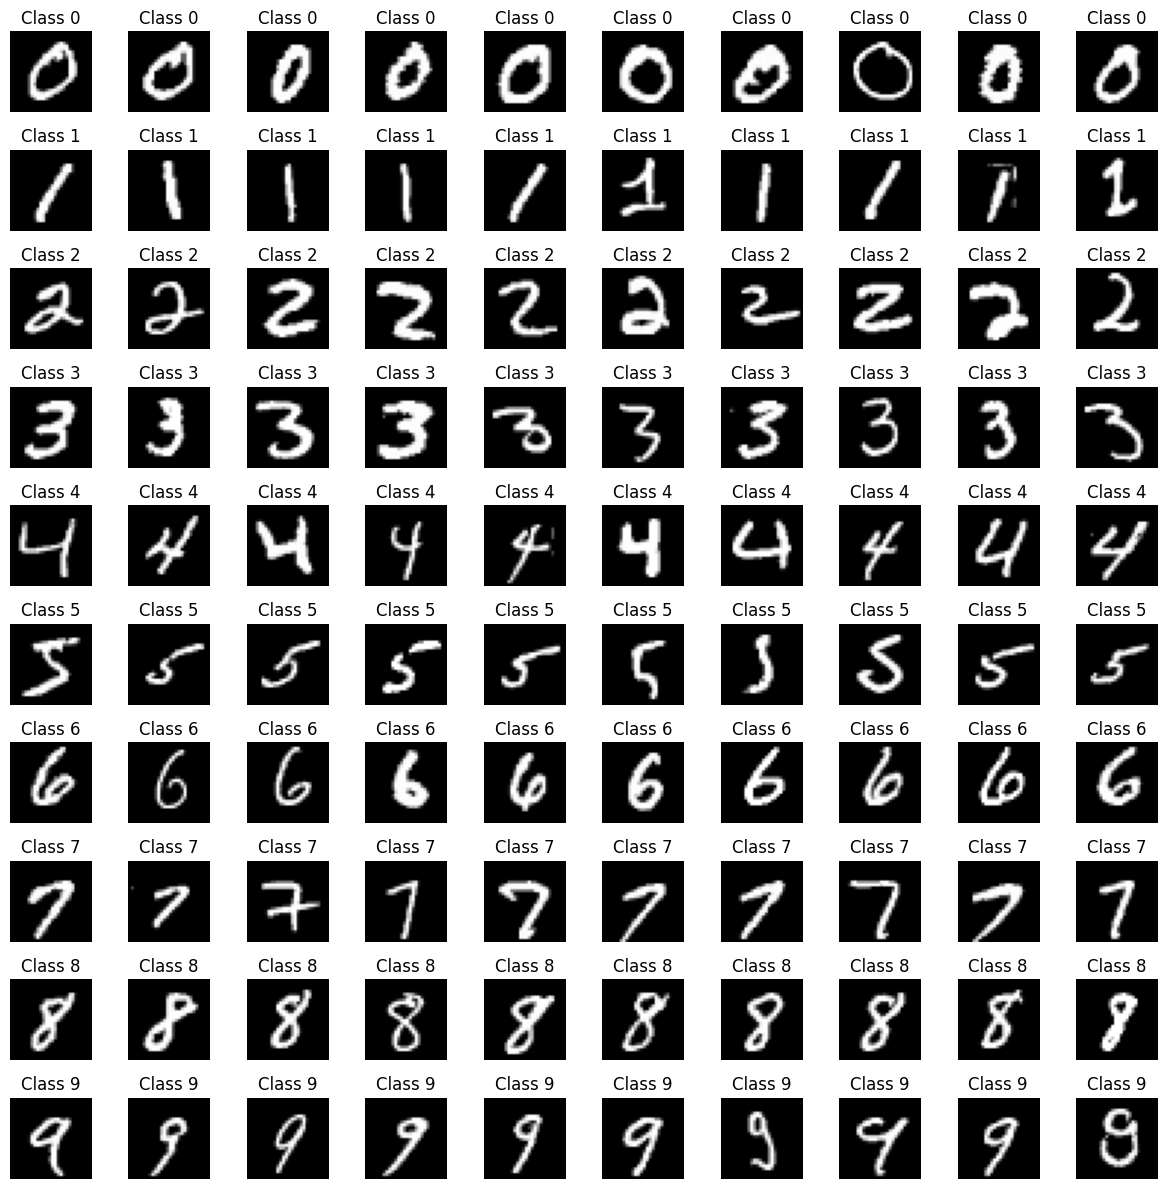

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_condensed_images_per_class(dataset, num_images_per_class):
    classes = dataset.dataset.targets.unique()
    fig, axes = plt.subplots(len(classes), num_images_per_class, figsize=(12, 12))

    for i, class_label in enumerate(classes):
        class_indices = (dataset.dataset.targets == class_label).nonzero(as_tuple=True)[0]
        selected_indices = class_indices[:num_images_per_class]

        for j, idx in enumerate(selected_indices):
            img, label = dataset.dataset[idx]
            img = img.numpy().squeeze()
            axes[i, j].imshow(img, cmap='gray')
            axes[i, j].axis('off')
            axes[i, j].set_title(f'Class {label}')

    plt.tight_layout()
    plt.show()

# Assuming condensed_dataset is your condensed dataset
visualize_condensed_images_per_class(condensed_dataset, num_images_per_class=10)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR

# Assuming you already have the MLP class definition and the synthetic dataset (condensed_dataset)

# Hyperparameters
lr_model = 0.01
num_opt_steps_model = 20  # Number of epochs
minibatch_size = 32  # Adjust as needed

# Initialize the model
model = MLP(channel=1, num_classes=10)

# Define data loader for the synthetic dataset
synthetic_loader = DataLoader(condensed_dataset, batch_size=minibatch_size, shuffle=True)

# Define optimizer for the model
optimizer_model = optim.SGD(model.parameters(), lr=lr_model)

# Define learning rate scheduler (cosine annealing)
scheduler = CosineAnnealingLR(optimizer_model, T_max=num_opt_steps_model, eta_min=0.0001)

# Training loop
for epoch in range(num_opt_steps_model):
    for data, target in synthetic_loader:
        # Zero the gradients
        optimizer_model.zero_grad()

        # Forward pass
        output = model(data)
        loss = F.cross_entropy(output, target)

        # Backward pass and optimization
        loss.backward()
        optimizer_model.step()

    # Update learning rate
    scheduler.step()

    # Print the loss after each epoch if desired
    print(f'Epoch {epoch + 1}/{num_opt_steps_model}, Loss: {loss.item()}, Learning Rate: {scheduler.get_last_lr()[0]}')

# Your model is now trained on the synthetic dataset


Epoch 1/20, Loss: 2.369346857070923, Learning Rate: 0.009939057285945933
Epoch 2/20, Loss: 2.211501359939575, Learning Rate: 0.009757729755661013
Epoch 3/20, Loss: 2.2082347869873047, Learning Rate: 0.009460482294732423
Epoch 4/20, Loss: 2.3114798069000244, Learning Rate: 0.009054634122155993
Epoch 5/20, Loss: 2.315648078918457, Learning Rate: 0.008550178566873413
Epoch 6/20, Loss: 2.276318073272705, Learning Rate: 0.007959536998847746
Epoch 7/20, Loss: 2.123181104660034, Learning Rate: 0.00729725297371076
Epoch 8/20, Loss: 2.211454153060913, Learning Rate: 0.006579634122155994
Epoch 9/20, Loss: 2.168917655944824, Learning Rate: 0.005824350601949147
Epoch 10/20, Loss: 2.3164165019989014, Learning Rate: 0.005050000000000002
Epoch 11/20, Loss: 2.1586191654205322, Learning Rate: 0.004275649398050861
Epoch 12/20, Loss: 2.3302125930786133, Learning Rate: 0.003520365877844012
Epoch 13/20, Loss: 2.254007339477539, Learning Rate: 0.0028027470262892446
Epoch 14/20, Loss: 2.238257884979248, Lear

In [ ]:
import torch
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Assuming you already have the MLP class definition and the trained model

# Load the MNIST testing dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
mnist_test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

# Create a DataLoader for the testing dataset
test_loader = DataLoader(mnist_test_dataset, batch_size=64, shuffle=False)

# Put the model in evaluation mode
model.eval()

correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        # Forward pass
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f'Test Accuracy: {100 * accuracy:.2f}%')


Test Accuracy: 26.64%
